In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [5]:
placement_grid = np.load('placement_grid.npy')
pathing_grid = np.load('pathing_grid.npy')

In [6]:
def show_map(_ndarray, colors = ('white', 'black')):
    cmap = ListedColormap(colors)
    plt.matshow(_ndarray, cmap=cmap)
    plt.show()

In [7]:
def octile_offset(distance):
    octile = np.fromfunction(lambda i, j: 1.414 * np.minimum(i, j) + np.absolute(i - j), (distance+1, distance+1))
    for x, y in zip(*np.where(octile.astype(int) == distance)):
        yield from {(x, y), (x, -y), (-x, y), (-x, -y)}

In [39]:
import math
from collections import defaultdict

def get_depth_map(map_array):
    depth_map = np.zeros_like(map_array, dtype=int)
    walls = set(zip(*np.where(map_array == 0)))

    for ix, iy in np.ndindex(map_array.shape):
        current_depth = -1
        while True:
            if depth_map[ix][iy] != 0:
                break

            for offset_x, offset_y in octile_offset(current_depth):
                if (ix + offset_x, iy + offset_y) in walls:
                    depth_map[ix][iy] = current_depth
                    break
            else:
                current_depth += 1
                continue
            break

    depth_map -= 2
    depth_list = {val: set(zip(*np.where(depth_map == val))) for val in range(0, np.max(depth_map)+1)}
    return depth_map, depth_list

def get_depth_map_2(map_array, max_depth):
    depth_map = np.zeros_like(map_array, dtype=int)
    walls = set(zip(*np.where(map_array == 0)))
    depth_list = defaultdict(list)


    current_depth = 0
    for ix, iy in zip(*np.where(map_array == 1)):
        current_depth -= 1
        wall_found = False
        wall_threshold = 0
        wall_counter = 0
        while True:
            if depth_map[ix][iy] != 0:
                break

            for offset_x, offset_y in octile_offset(current_depth):
                if (ix + offset_x, iy + offset_y) in walls:
                    wall_counter += 1
                    # if not wall_found:
                    #     wall_threshold = (max_depth - current_depth)/4 + 1
                    # if wall_counter >= wall_threshold:
                    depth = math.floor(math.log(current_depth, 2) + 1)
                    depth_map[ix][iy] = depth
                    depth_list[depth].append((ix, iy))
                    break
            else:
                current_depth += 1

    return depth_map, depth_list

In [48]:
depth_map, depth_list = get_depth_map(placement_grid)

In [49]:
from typing import Iterable

def deepest_points(depth_list, n_depths) -> Iterable[set]:
    depths = sorted(depth_list, reverse=True)[:n_depths]
    for depth in depths:
        yield depth_list[depth]

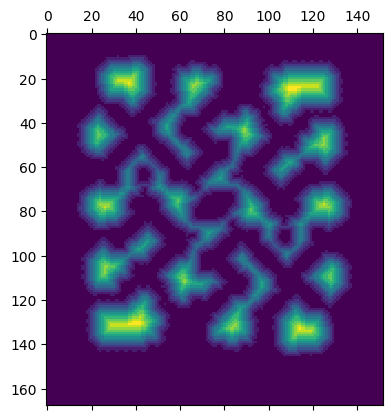

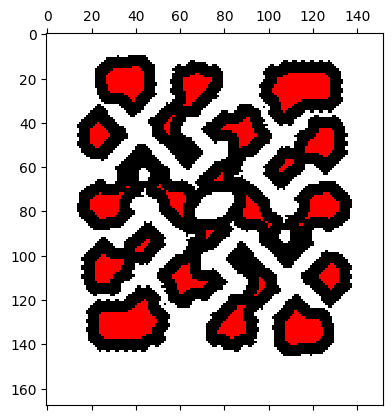

In [51]:
plt.matshow(depth_map)
plt.show()
placement_grid_depth = placement_grid.copy()
for ll in deepest_points(depth_list, 7):
    for p in ll:
        placement_grid_depth[p] = 2
show_map(placement_grid_depth, ('white', 'black', 'red'))

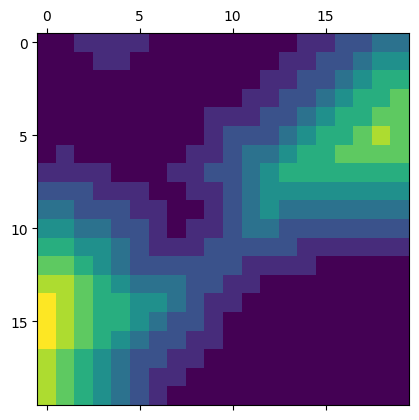

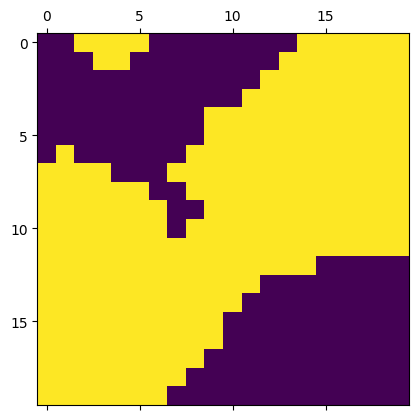

In [13]:
xd = depth_map[60:80, 60:80]
plt.matshow(xd)
plt.matshow(placement_grid[60:80, 60:80])

In [329]:
print(depth_map)

[[0 0 1 2 2 1 0 0 0 0 0 0 0 0 2 2 3 3 3 3]
 [0 0 0 3 3 0 0 0 0 0 0 0 0 3 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 3 3 3 2 2 2 3 3 3 3 4]
 [0 0 0 0 0 0 0 0 0 3 3 3 3 2 3 3 3 3 3 3]
 [0 3 0 0 0 0 0 0 3 3 2 2 3 3 3 3 3 3 3 3]
 [3 3 2 2 0 0 0 1 1 2 2 2 3 3 3 3 3 3 3 3]
 [3 2 2 2 1 1 0 0 1 2 2 3 3 3 3 3 3 3 3 3]
 [2 2 2 2 2 2 1 0 0 2 2 3 3 3 2 2 2 2 2 2]
 [3 3 3 2 2 2 1 0 1 2 2 2 2 2 2 2 2 2 2 2]
 [3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1]
 [3 3 3 3 3 3 2 2 2 2 2 2 1 1 1 0 0 0 0 0]
 [3 3 3 3 3 3 3 2 2 2 2 1 0 0 0 0 0 0 0 0]
 [4 4 3 3 3 3 3 2 2 2 1 0 0 0 0 0 0 0 0 0]
 [4 4 3 3 3 3 2 2 2 1 0 0 0 0 0 0 0 0 0 0]
 [4 3 3 3 3 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0]
 [4 3 3 3 3 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0]
 [4 3 3 3 3 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 3 3 3 3 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [27]:
import heapq
import random

def build_zone_map(depth_map, depth_list):
    zone_map = np.zeros(depth_map.shape, dtype=np.int32)
    gate_cluster_map = np.zeros(depth_map.shape, dtype=np.int32)

    current_water_level = np.max(depth_map)
    while current_water_level >= 0:
        for ix, iy in sorted(depth_list[current_water_level], key=lambda x: x[0]**2 + x[0]**2):
            neighbors = get_labeled_neighbors(ix, iy, zone_map)

            if len(neighbors) > 1:
                if len(set(neighbors)) > 0:
                    gate_cluster_map[ix][iy] = 1
                zone_map[ix][iy] = min(neighbors)
            else:
                zone_map[ix][iy] = get_new_label(zone_map)

        current_water_level -= 1
        break

    return zone_map, gate_cluster_map

def get_labeled_neighbors(x, y, zone_map):
    neighbors = []

    for dy, dx in {(0, 0), (0, 1), (0, -1), (0, 2), (0, -2), (0, 3), (0, -3), (0, -4), (0, 4), (0, -5), (0, 5), (1, 0), (-1, 0), (-1, 1), (1, 1), (-1, -1), (1, -1), (-1, -2), (1, 2), (1, -2), (-1, 2), (1, -3), (-1, 3), (1, 3), (-1, -3), (1, -4), (-1, 4), (1, 4), (-1, -4), (-2, 0), (2, 0), (2, -1), (-2, -1), (-2, 1), (2, 1), (2, -2), (-2, 2), (-2, -2), (2, 2), (2, 3), (-2, 3), (2, -3), (-2, -3), (2, 4), (-2, 4), (2, -4), (-2, -4), (-3, 0), (3, 0), (3, 1), (-3, -1), (3, -1), (-3, 1), (-3, 2), (3, 2), (3, -2), (-3, -2), (-3, 3), (-3, -3), (3, 3), (3, -3), (3, -4), (-3, 4), (3, 4), (-3, -4), (4, 0), (-4, 0), (4, -1), (4, 1), (-4, -1), (-4, 1), (4, -2), (-4, -2), (4, 2), (-4, 2), (-4, 3), (-4, -3), (4, -3), (4, 3), (-5, 0), (5, 0)}:
        ny, nx = y + dy, x + dx
        if zone_map.shape[0] > nx >= 0 and zone_map.shape[1] > ny >= 0 and zone_map[nx][ny] > 0:
            neighbors.append(zone_map[nx][ny])

    return neighbors

def get_new_label(zone_map):
    return np.max(zone_map) + 1

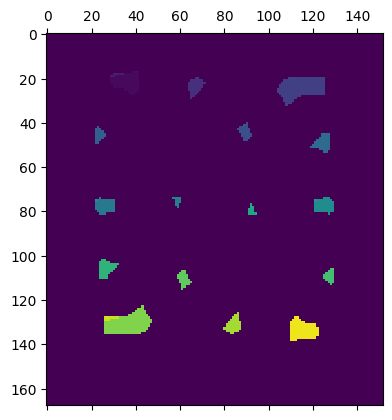

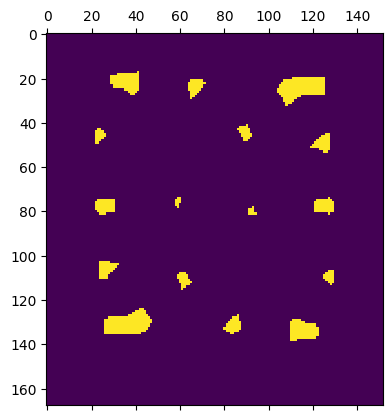

In [28]:
zone_map, gate_map = build_zone_map(depth_map, depth_list)
plt.matshow(zone_map)
plt.matshow(gate_map)

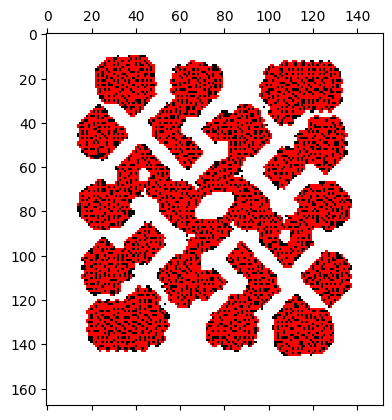

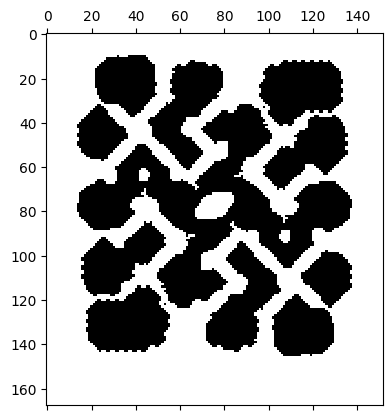

In [311]:
xx = placement_grid.copy()
xx[gate_map == 1] = 2
show_map(xx, colors=('w', 'black', 'red'))
show_map(placement_grid)

In [8]:

def points_in_circle_np(radius):
    a = np.arange(radius + 1)
    for x, y in zip(*np.where(a[:,np.newaxis]**2 + a**2 <= radius**2)):
        yield from {(x, y), (x, -y), (-x, y), (-x, -y)}

print(list(points_in_circle_np(5)))

[(0, 0), (0, 1), (0, -1), (0, 2), (0, -2), (0, 3), (0, -3), (0, -4), (0, 4), (0, -5), (0, 5), (1, 0), (-1, 0), (-1, 1), (1, 1), (-1, -1), (1, -1), (-1, -2), (1, 2), (1, -2), (-1, 2), (1, -3), (-1, 3), (1, 3), (-1, -3), (1, -4), (-1, 4), (1, 4), (-1, -4), (-2, 0), (2, 0), (2, -1), (-2, -1), (-2, 1), (2, 1), (2, -2), (-2, 2), (-2, -2), (2, 2), (2, 3), (-2, 3), (2, -3), (-2, -3), (2, 4), (-2, 4), (2, -4), (-2, -4), (-3, 0), (3, 0), (3, 1), (-3, -1), (3, -1), (-3, 1), (-3, 2), (3, 2), (3, -2), (-3, -2), (-3, 3), (-3, -3), (3, 3), (3, -3), (3, -4), (-3, 4), (3, 4), (-3, -4), (4, 0), (-4, 0), (4, -1), (4, 1), (-4, -1), (-4, 1), (4, -2), (-4, -2), (4, 2), (-4, 2), (-4, 3), (-4, -3), (4, -3), (4, 3), (-5, 0), (5, 0)]
